In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
PATH = "data/cifar10/"

In [3]:
from fastai.conv_learner import *

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
classes = os.listdir("data/cifar10/train")

In [5]:
import pickle

In [6]:
with open("images_as_matrix.obj", "rb") as f:
    imageMatrix = pickle.load(f)

In [7]:
with open("images_as_matrix_val.obj", "rb") as f:
    imageMatrixVal = pickle.load(f)

In [8]:
average = imageMatrix.mean(axis=(0,1,2))

In [9]:
std = imageMatrix.std(axis=(0,1,2))

In [10]:
stats = (average, std)

In [7]:
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [15]:
def get_data(sz, bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, val_name="test")
#     return ImageClassifierData.from_arrays('.',imageMatrix, imageMatrixVal, bs=bs, tfms=tfms)

In [16]:
data = get_data(32,4)

In [18]:
x,y=next(iter(data.trn_dl))

In [19]:
x.shape

torch.Size([4, 3, 32, 32])

In [9]:
bs=256

In [10]:
data = get_data(32, bs)

In [14]:
class simple_net(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for i in self.layers:
            t_l = i(x)
            x = F.relu(t_l)
        return F.log_softmax(x, dim=-1)

In [60]:
?F.log_softmax

In [61]:
learn = ConvLearner.from_model_data(simple_net([32*32*3, 40,10]), data)

In [62]:
learn.lr_find()

epoch      trn_loss   val_loss   accuracy                   
    0      2.240085   2.302586   0.1       



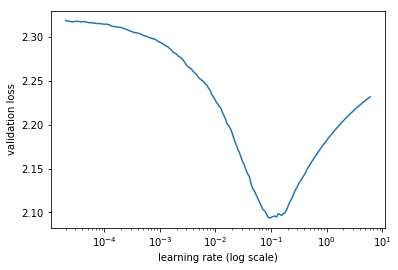

In [63]:
learn.sched.plot()

In [64]:
%time learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.793455   1.680967   0.4069    
    1      1.71078    1.582373   0.4454                     

CPU times: user 2min 2s, sys: 44.6 s, total: 2min 46s
Wall time: 40.7 s


[1.582373244857788, 0.4454]

In [65]:
learn.fit(1e-2, 2, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.63526    1.532028   0.4667    
    1      1.605964   1.508295   0.4723                     
    2      1.618868   1.50408    0.4706                     
    3      1.57169    1.482495   0.4853                     



[1.4824953426361085, 0.4853]

## CNN

In [167]:
class convNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.convLayers = nn.ModuleList([nn.Conv2d(layers[i], layers[i+1], kernel_size=3, stride=2) for i in range(len(layers)-1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
    def forward(self, data):
        for i in self.convLayers:
            data = F.relu(i(data))
        x = self.pool(data)
        x = x.view(x.size(0), -1)
        print
        return F.log_softmax(self.out(x), dim=-1)

In [25]:
x[0].shape

torch.Size([3, 32, 32])

In [168]:
learn = ConvLearner.from_model_data(convNet([3, 20, 40, 80], 10), data)

In [169]:
learn.lr_find(end_lr=100)

 26%|██▌       | 50/196 [00:08<00:18,  7.81it/s, loss=2.31]

KeyboardInterrupt: 

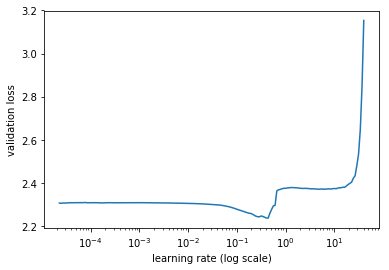

In [82]:
learn.sched.plot()

In [83]:
learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.718588   1.596212   0.4108    
    1      1.515265   1.488096   0.4623                     


[1.4880962749481201, 0.4623]

In [84]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.454518   1.377924   0.4983    
    1      1.341475   1.269083   0.5431                     
    2      1.278816   1.215246   0.5633                     
    3      1.246033   1.183273   0.5736                     
CPU times: user 12min 6s, sys: 1min 47s, total: 13min 54s
Wall time: 2min 3s


[1.1832725400924682, 0.5736]

## refactored

In [87]:
class ConvLayer(nn.Module):
    def __init__(self, inp, oup):
        super().__init__()
        self.layer = nn.Conv2d(inp, oup, kernel_size=3, stride=2, padding=1)
    def forward(self, data):
        return F.relu(self.layer(data))

In [94]:
class simpleNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.linear = nn.Linear(layers[-1], c)
    def forward(self, data):
        for i in self.layers:
            data = i(data)
        data = F.adaptive_avg_pool2d(data, 1)
        data = data.view(data.size(0), -1)
        return F.log_softmax(self.linear(data), dim=-1)

In [95]:
learn = ConvLearner.from_model_data(simpleNet2([3, 20, 40, 80], 10), data)

In [96]:
learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.828059   1.721424   0.3754    
    1      1.582051   1.447273   0.4736                     


[1.4472729572296144, 0.4736]

In [97]:
learn.fit(1e-1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.385572   1.312284   0.5263    
    1      1.314671   1.243981   0.5546                     


[1.2439812431335449, 0.5546]

# Batch Norm

In [31]:
# class batchNorm(nn.Module):
#     def __init__(self, ni, nf, stride=2, kernel_size=3):
#         super().__init__()
#         self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
#                               bias=False, padding=1)
#         self.a = nn.Parameter(torch.zeros(nf,1,1))
#         self.m = nn.Parameter(torch.ones(nf,1,1))
        
#     def forward(self, x):
#         x = F.relu(self.conv(x))
#         x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
#         if self.training:
#             self.means = x_chan.mean(1)[:,None,None]
#             self.stds  = x_chan.std (1)[:,None,None]
#         return (x-self.means) / self.stds *self.m + self.a
class batchNorm(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, stride=stride, kernel_size=kernel_size, bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
    def forward(self, data):
#         x = F.relu(self.conv(x))
#         x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
#         if self.training:
#             self.means = x_chan.mean(1)[:,None,None]
#             self.stds  = x_chan.std (1)[:,None,None]
#         return (x-self.means) / self.stds *self.m + self.a
        data = F.relu(self.conv(data))
        np_data = to_np(data)
        if self.training:
            self.means = T(np_data.mean(axis=(0,2,3)))[:,None, None]
            self.variance = T(np_data.std(axis=(0,2,3)))[:,None, None]
        return (data-self.means)/self.variance*self.m+self.a


In [23]:
class miniNet3(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([batchNorm(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.linear = nn.Linear(layers[-1], c)
    def forward(self, data):
        data = self.conv1(data)
        for i in self.layers:
            data = i(data)
        data = F.adaptive_max_pool2d(data, 1)
        data = data.view(data.size(0), -1)
        return F.log_softmax(self.linear(data), dim=-1)

In [24]:
learner = ConvLearner.from_model_data(miniNet3([10, 20, 40, 80, 160], 10), data)

In [25]:
%time learner.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.573453   1.421636   0.4858    
    1      1.351261   1.247557   0.5508                     
CPU times: user 16min 42s, sys: 1min 9s, total: 17min 52s
Wall time: 2min 43s


[1.2475569946289062, 0.5508]

In [26]:
%time learner.fit(1e-2, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.172121   1.093992   0.6101    
    1      1.120569   1.048546   0.6298                     
    2      1.063667   0.994555   0.6439                     
    3      1.026209   0.961156   0.6628                     
CPU times: user 33min 33s, sys: 2min 25s, total: 35min 58s
Wall time: 5min 36s


[0.9611563280105591, 0.6628]

## Deep Batch Norm

In [38]:
class deepBatch(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layer1 = nn.ModuleList([batchNorm(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.layer2 = nn.ModuleList([batchNorm(layers[i+1], layers[i+1], 1) for i in range(len(layers)-1)])
        self.linear = nn.Linear(layers[-1], c)
    def forward(self, data):
        data = self.conv1(data)
        for l, l1 in zip(self.layer1, self.layer2):
            data = l(data)
            data = l1(data)
        data = F.adaptive_max_pool2d(data, 1)
        data = data.view(data.size(0), -1)
        return F.log_softmax(self.linear(data), dim=-1)

In [39]:
learnerD = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [40]:
%time learnerD.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.576658   1.478943   0.4533    
    1      1.357938   1.271064   0.5481                     
CPU times: user 26min 46s, sys: 1min 41s, total: 28min 27s
Wall time: 5min 14s


[1.2710642599105835, 0.5481]

In [45]:
class resnet(batchNorm):
    def forward(self, x):
        return x+super().forward(x)

In [46]:
class deepBatchRes(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layer1 = nn.ModuleList([batchNorm(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.layer2 = nn.ModuleList([batchNorm(layers[i+1], layers[i+1], 1) for i in range(len(layers)-1)])
        self.layer3 = nn.ModuleList([batchNorm(layers[i+1], layers[i+1], 1) for i in range(len(layers)-1)])
        self.linear = nn.Linear(layers[-1], c)
    def forward(self, data):
        data = self.conv1(data)
        for l, l1, l2 in zip(self.layer1, self.layer2, self.layer3):
            data = l2(l1(l(data)))
        data = F.adaptive_max_pool2d(data, 1)
        data = data.view(data.size(0), -1)
        return F.log_softmax(self.linear(data), dim=-1)

In [47]:
learnerResNet=ConvLearner.from_model_data(deepBatchRes([10, 20, 40, 80, 160], 10), data) 

In [48]:
wd=1e-5
%time learnerResNet.fit(1e-2, 2, wds=wd)

  8%|▊         | 16/196 [00:21<03:31,  1.18s/it, loss=2.45]

KeyboardInterrupt: 